In [21]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    py_file_location = "/content/drive/MyDrive/Tesis/Git/RedVolcanica"
    %cd "{py_file_location}" 
    IN_COLAB = True
except:
    IN_COLAB = False
print(IN_COLAB)  

False


In [22]:
import importlib

import RedFunciones.visualizacion as visualizacion
import RedFunciones.Generador as Generador
import RedFunciones.Discriminador as Discriminador
import RedFunciones.auxiliares as auxiliares
import RedFunciones.DataloaderVol as DataloaderVol
import RedFunciones.Checkpoint as Checkpoint

importlib.reload(auxiliares)
importlib.reload(visualizacion)
importlib.reload(Generador)
importlib.reload(Discriminador)
importlib.reload(DataloaderVol)
importlib.reload(Checkpoint)

import Auxiliares.BinaryAccuracy as bin_acc

In [23]:
import torch
from torch import nn
import torchaudio

from tqdm.auto import tqdm # Progress bar

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST #noned

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0) # Set for our testing purposes, please do not change!

import os
cwd = os.getcwd()
print(cwd)

cuda0 = torch.device('cuda:2')
cpu = 'cpu'
device = torch.device(cuda0 if torch.cuda.is_available() else cpu)

/home/fgrijalva/RedVolcanica/RedVolcanica


criterion: the loss function

n_epochs: the number of times you iterate through the entire 
dataset when training

z_dim: the dimension of the noise vector

display_step: how often to display/visualize the images

batch_size: the number of images per forward/backward pass

lr: the learning rate

device: the device type

In [24]:
h5_filename = cwd + '/baseh5/baseSR10.h5'
nombre = 'master'
nombre_carga = 'master-2022-04-04.pt'

criterion = nn.BCEWithLogitsLoss()

mnist_shape = (1, 129, 33) #tamaño imagen
n_classes = 2 # numkero etiquetas
z_dim = 64

n_epochs = 25
display_step = 50
batch_size = 16

lrg = 0.001
beta_1_g = 0.5
beta_2_g = 0.999
repeats_g = 5

lrd = 0.00006
beta_1_d = 0.5
beta_2_d = 0.999
d_repeats = 1

mean = 0
std = 1

guardar = False
cargar = False
save_steep = 1

epoch_temp = -1
gen_loss_temp = torch.empty([])
disc_loss_temp = torch.empty([])

In [25]:
mean_p = False

regularizaM = True
reg_lambda = 0.001

In [26]:
if mean_p:
    myDataA = DataloaderVol.VolcanoDatasetH5(h5_filename)
    dataloaderA = DataLoader(
        myDataA,
        batch_size=batch_size,
        shuffle=True)

    def get_mean_and_std(dataloader):
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0,2,3])
            channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
            num_batches += 1    
        mean = channels_sum / num_batches
        # std = sqrt(E[X^2] - (E[X])^2)
        std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
        return mean.item(), std.item()

    mean, std = get_mean_and_std(dataloaderA)
    print(mean)
    print(std)

In [27]:
#cargar datos
if mean_p:
    transform = transforms.Compose([
        #transforms.ToTensor(),
        transforms.Normalize((mean,), (std,)),
        #torchaudio.transforms.MelScale(sample_rate=50, n_stft=129)
    ])    
else:
    transform = transforms.Compose([
        #transforms.ToTensor(),
        #transforms.Normalize((mean,), (std,)),
        #torchaudio.transforms.MelScale(sample_rate=50, n_stft=129)
    ])    
myData = DataloaderVol.VolcanoDatasetH5(h5_filename, transform)

dataloader = DataLoader(
    myData,
    batch_size=batch_size,
    shuffle=True)

#a, b = next(iter(dataloader))
#print(a)

In [28]:
generator_input_dim, discriminator_im_chan = auxiliares.get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generador.Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lrg)
disc = Discriminador.Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lrd)
gen = gen.apply(auxiliares.weights_init)
disc = disc.apply(auxiliares.weights_init)

gen.train()
disc.train()
        
metric = bin_acc.BinaryAccuracy()

In [29]:
if cargar:
    compelto = Checkpoint.DIRECTORY + nombre_carga
    checkpoint = torch.load(compelto)
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])
    gen_opt.load_state_dict(checkpoint['gen_opt'])
    disc_opt.load_state_dict(checkpoint['disc_opt'])
    epoch_temp = checkpoint['epoch']
    gen_loss_temp = checkpoint['gen_loss']
    disc_loss_temp = checkpoint['dis_loss']
    print('Modelo cargado')
    print('epoch: ' + str(epoch_temp))

Epoch: 0


  0%|          | 0/385 [00:00<?, ?it/s]

Red Funcionando
Step 50: Generator loss: 0.6827650377750396, discriminator loss: 1.1100537490844726
Espectrogramas Generados


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


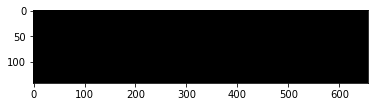

Espectrogramas Reales


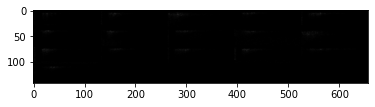

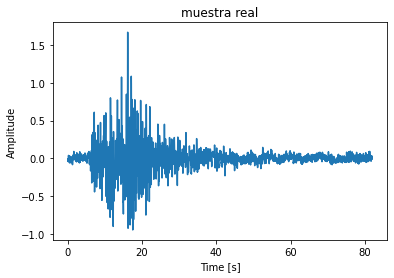

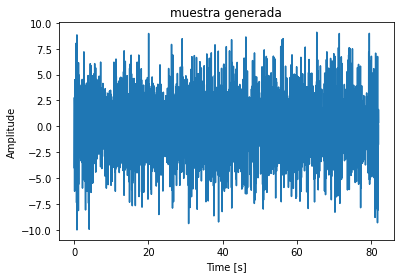

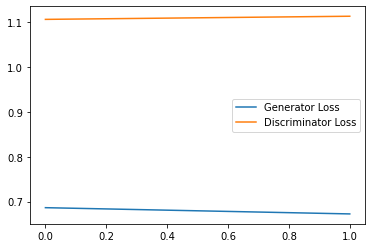

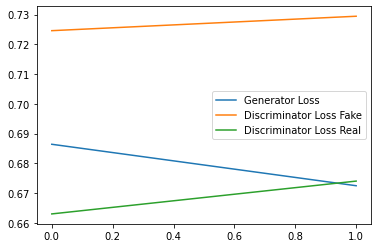

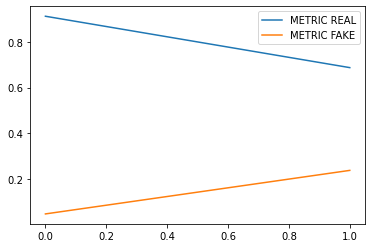

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100: Generator loss: 0.7039349067211151, discriminator loss: 1.104897141456604
Espectrogramas Generados


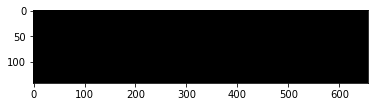

Espectrogramas Reales


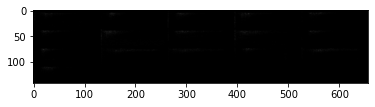

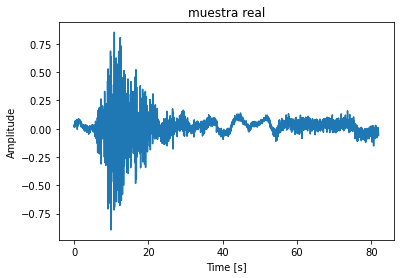

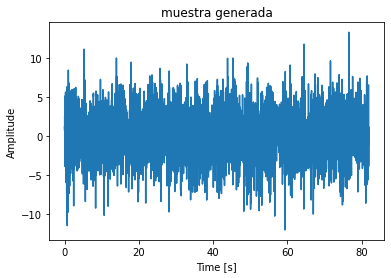

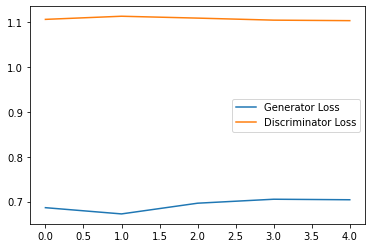

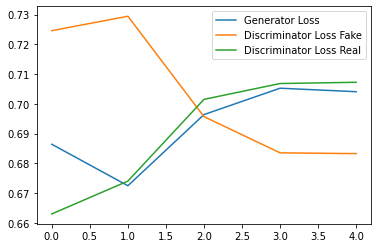

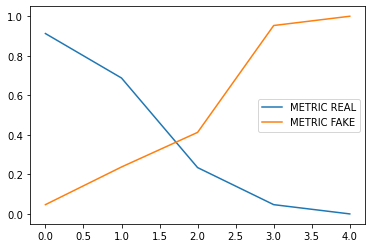

Step 150: Generator loss: 0.6928041837215424, discriminator loss: 1.1010509133338928
Espectrogramas Generados


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


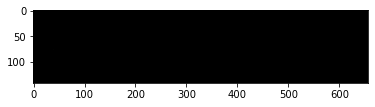

Espectrogramas Reales


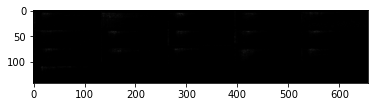

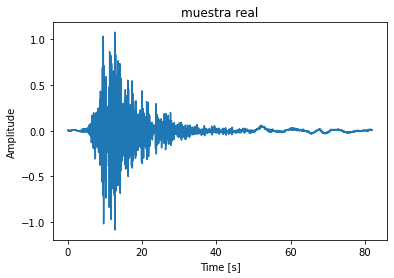

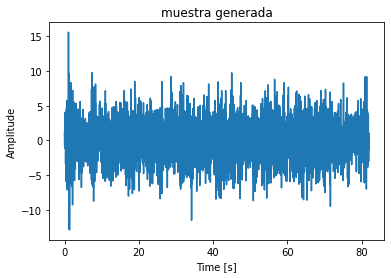

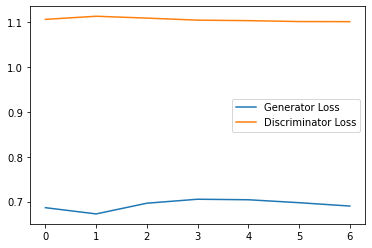

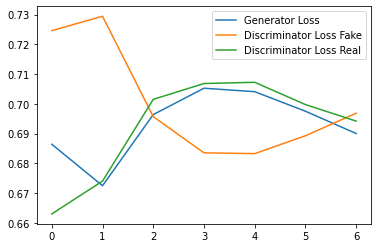

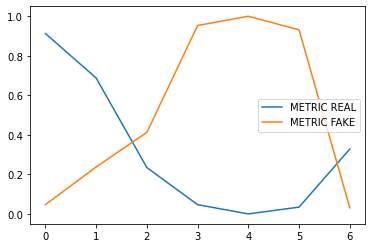

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 200: Generator loss: 0.6944008684158325, discriminator loss: 1.0953453922271728
Espectrogramas Generados


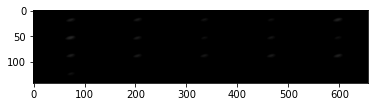

Espectrogramas Reales


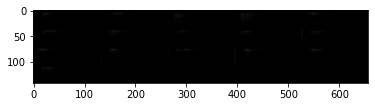

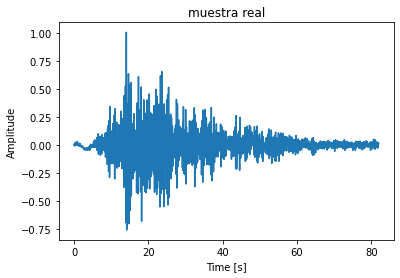

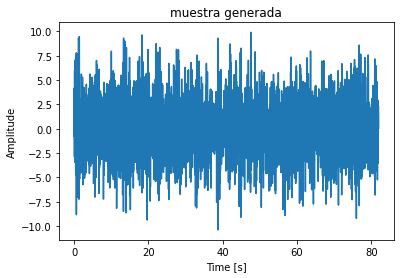

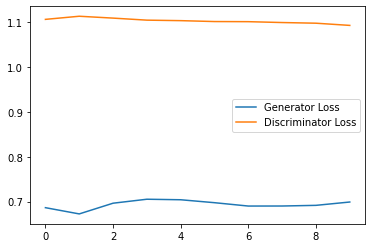

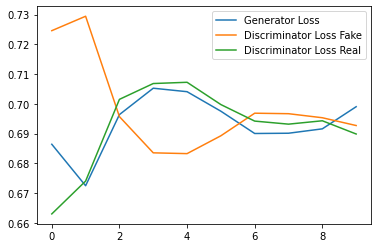

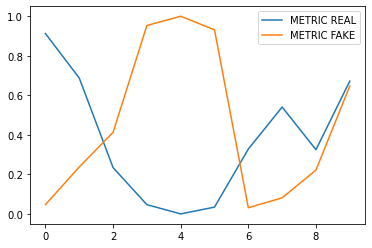

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250: Generator loss: 0.6936660321950913, discriminator loss: 1.0915190434455873
Espectrogramas Generados


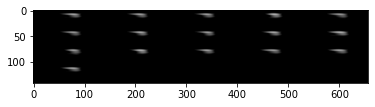

Espectrogramas Reales


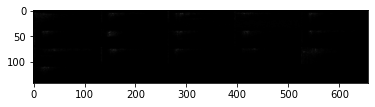

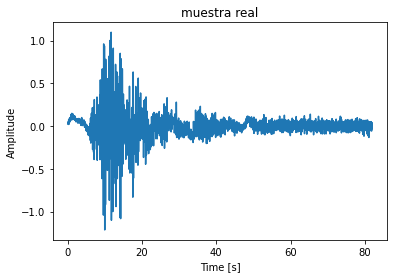

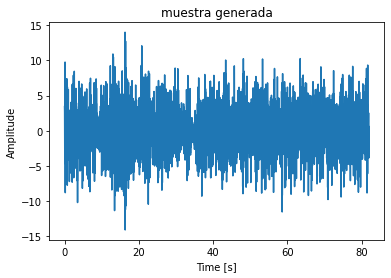

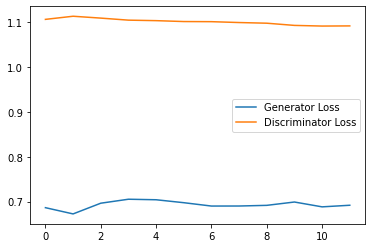

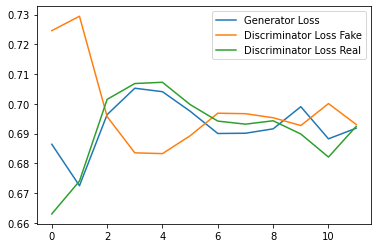

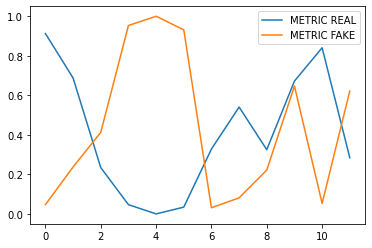

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 300: Generator loss: 0.7021336381435396, discriminator loss: 1.0846398663520813
Espectrogramas Generados


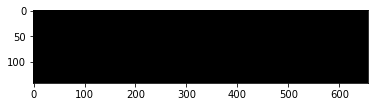

Espectrogramas Reales


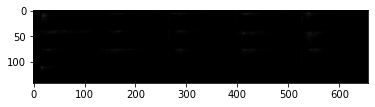

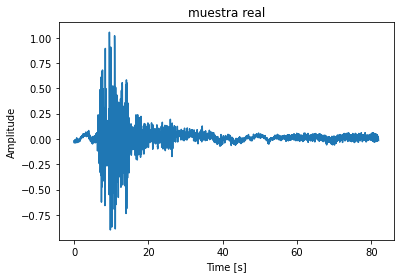

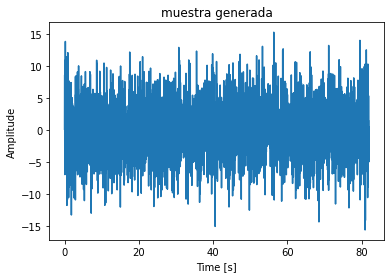

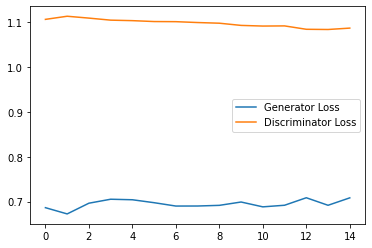

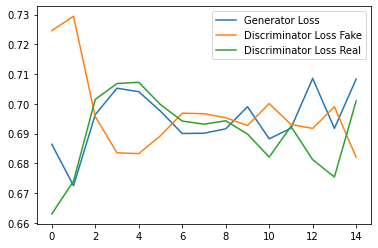

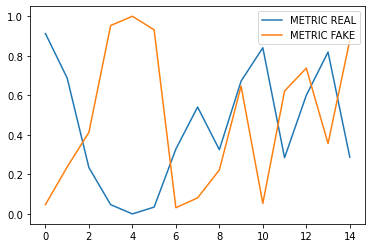

Step 350: Generator loss: 0.7043811445236206, discriminator loss: 1.082817633152008
Espectrogramas Generados


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


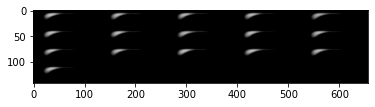

Espectrogramas Reales


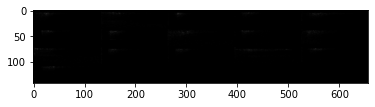

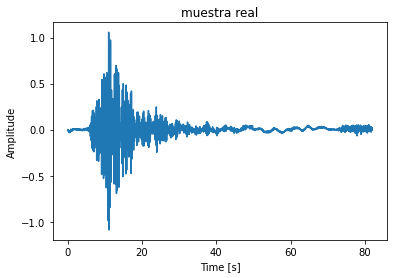

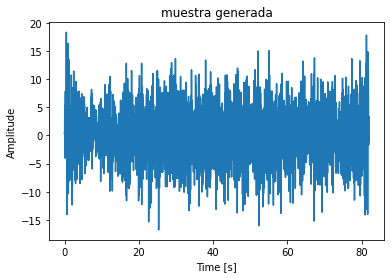

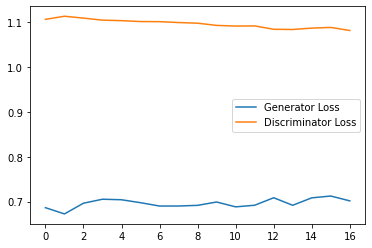

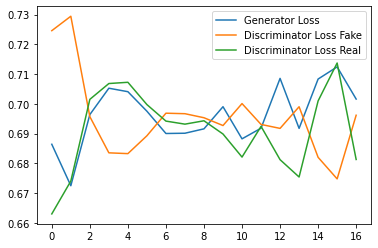

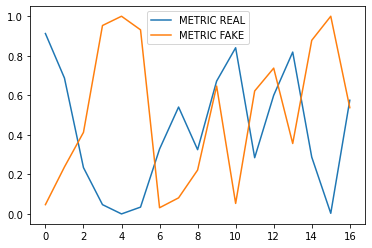

Epoch: 1


  0%|          | 0/385 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 400: Generator loss: 0.705081366300583, discriminator loss: 1.0796706008911132
Espectrogramas Generados


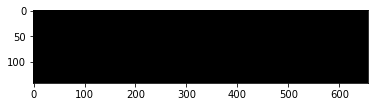

Espectrogramas Reales


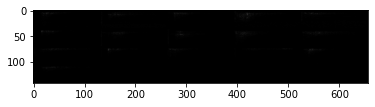

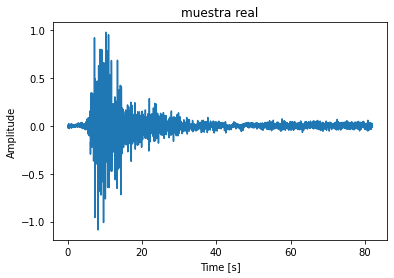

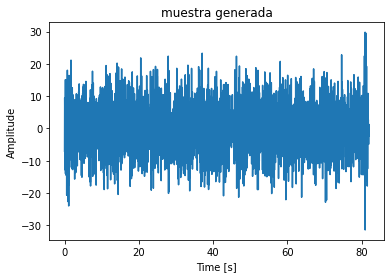

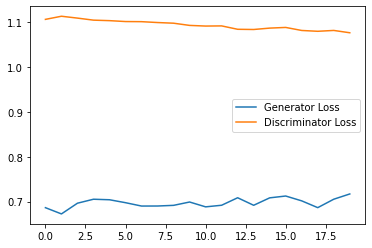

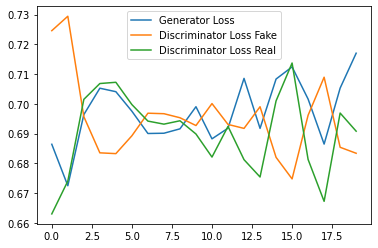

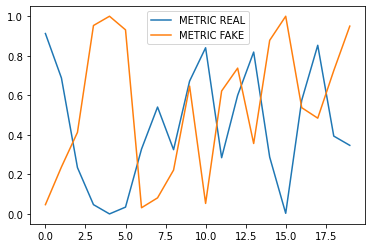

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 450: Generator loss: 0.7034843527078628, discriminator loss: 1.0783875608444213
Espectrogramas Generados


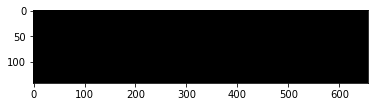

Espectrogramas Reales


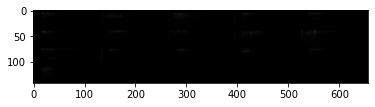

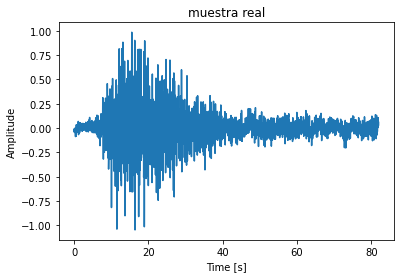

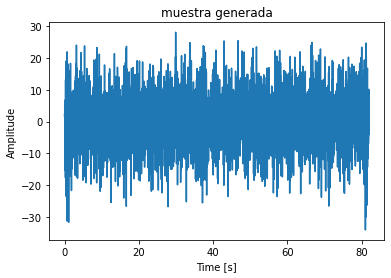

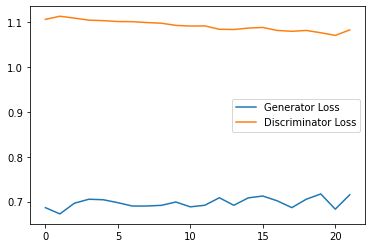

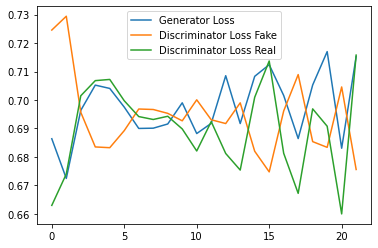

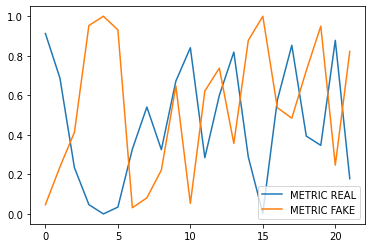

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500: Generator loss: 0.6985856485366824, discriminator loss: 1.0781754159927368
Espectrogramas Generados


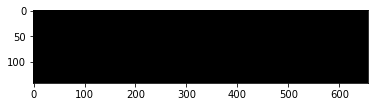

Espectrogramas Reales


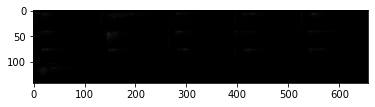

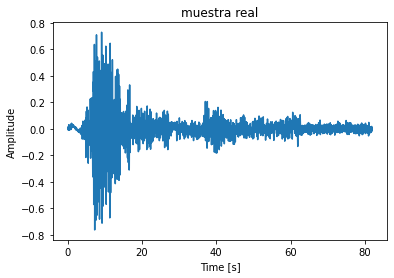

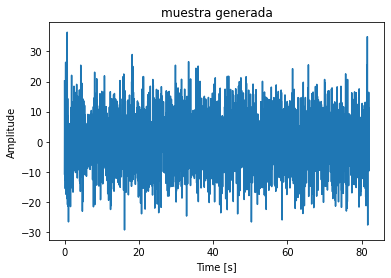

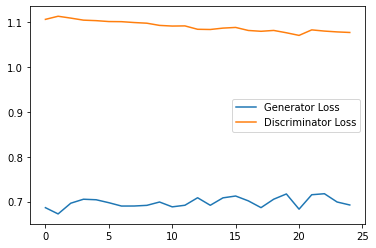

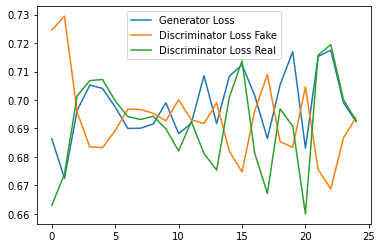

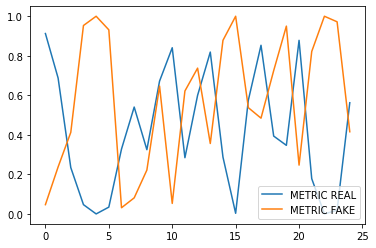

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 550: Generator loss: 0.6940109226703643, discriminator loss: 1.0725189661979675
Espectrogramas Generados


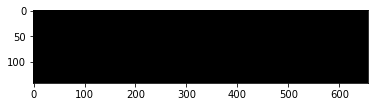

Espectrogramas Reales


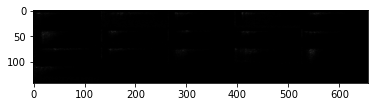

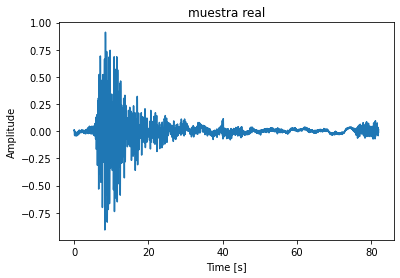

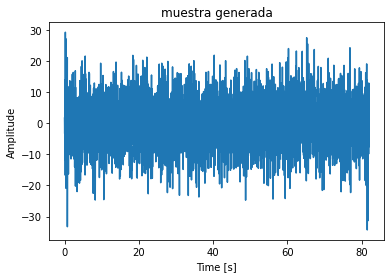

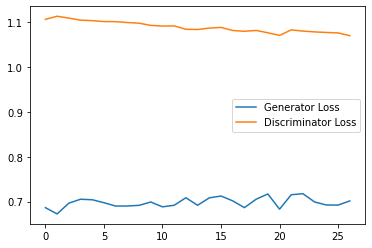

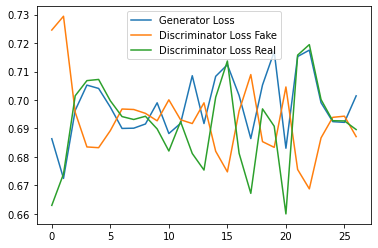

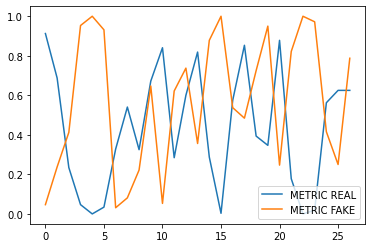

Step 600: Generator loss: 0.6934513691663742, discriminator loss: 1.0722845005989075
Espectrogramas Generados


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


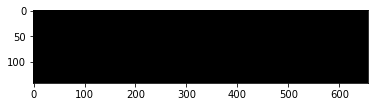

Espectrogramas Reales


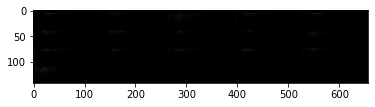

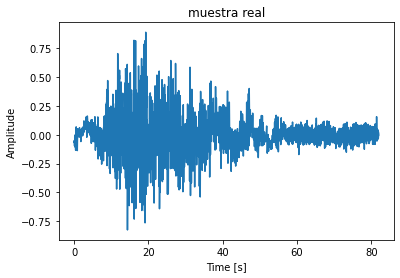

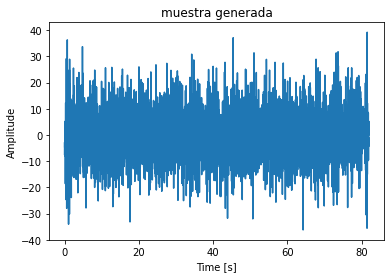

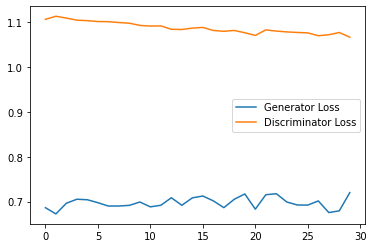

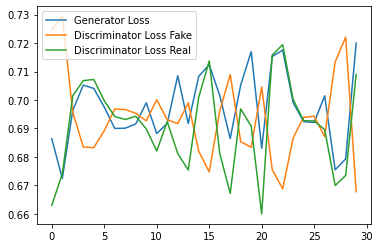

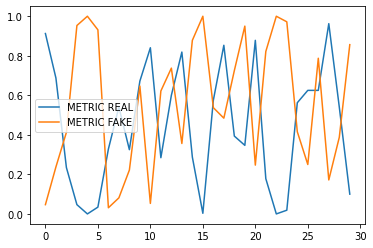

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 650: Generator loss: 0.7005045876502989, discriminator loss: 1.0644023871421815
Espectrogramas Generados


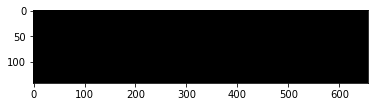

Espectrogramas Reales


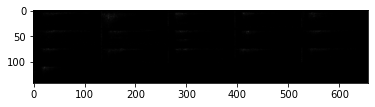

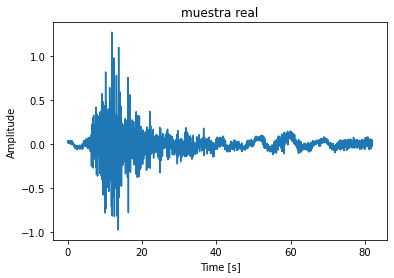

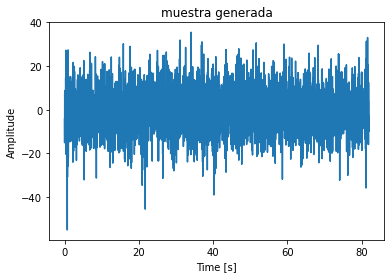

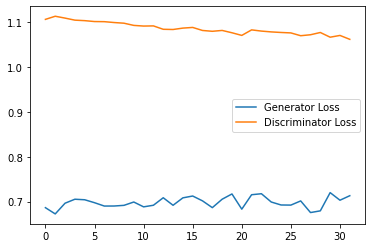

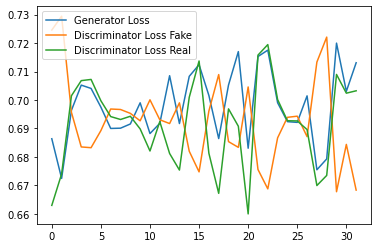

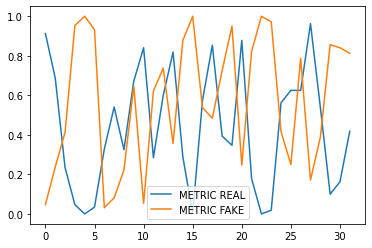

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 700: Generator loss: 0.7166063845157622, discriminator loss: 1.0348299849033356
Espectrogramas Generados


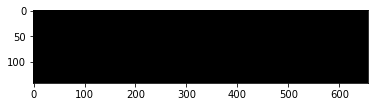

Espectrogramas Reales


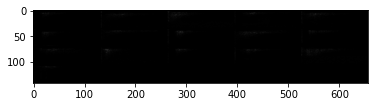

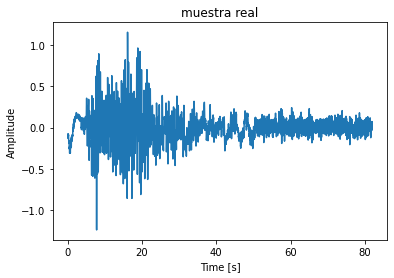

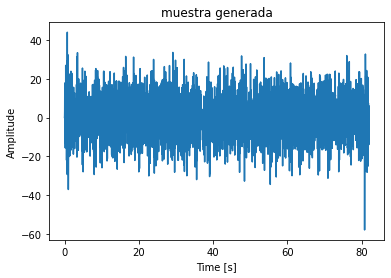

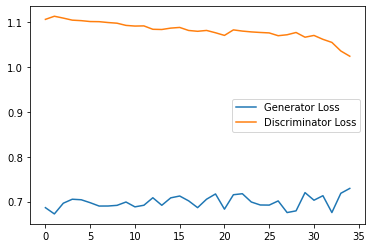

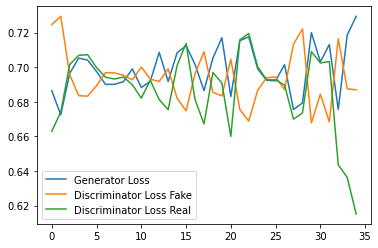

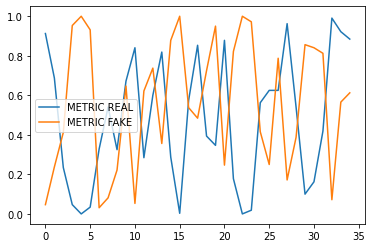

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750: Generator loss: 0.7516161761283875, discriminator loss: 1.053087501525879
Espectrogramas Generados


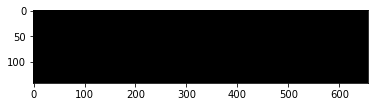

Espectrogramas Reales


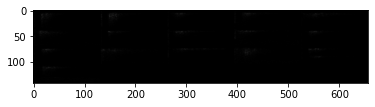

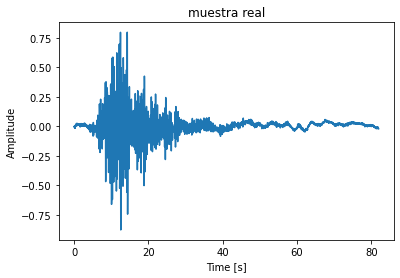

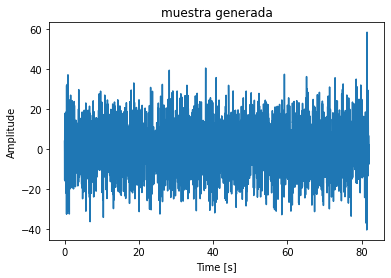

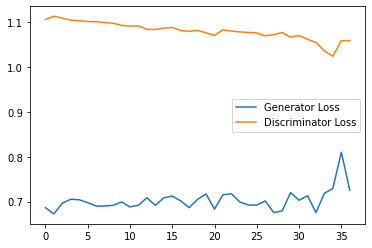

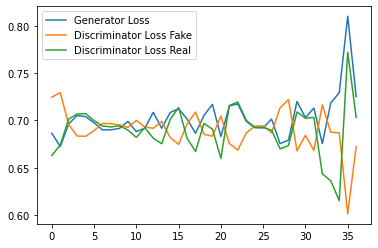

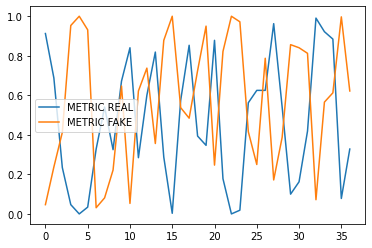

Epoch: 2


  0%|          | 0/385 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 800: Generator loss: 0.7048393733501434, discriminator loss: 1.0687895965576173
Espectrogramas Generados


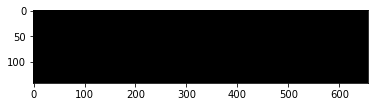

Espectrogramas Reales


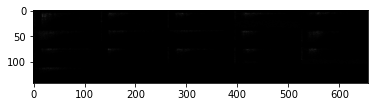

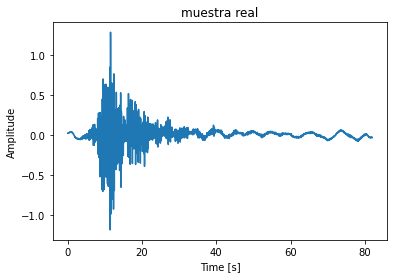

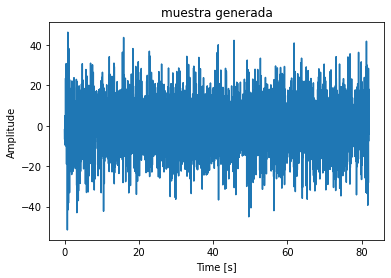

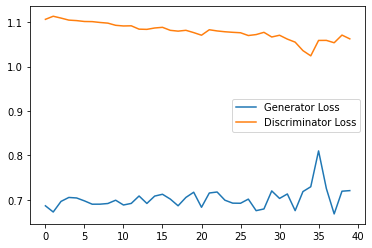

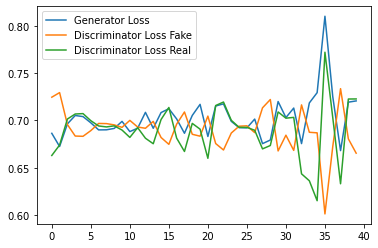

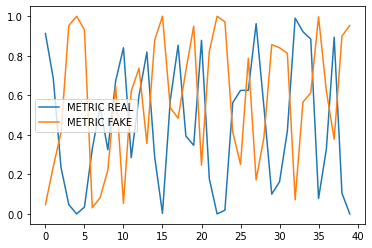

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 850: Generator loss: 0.7033144476413727, discriminator loss: 1.0599896836280822
Espectrogramas Generados


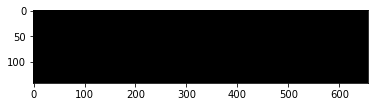

Espectrogramas Reales


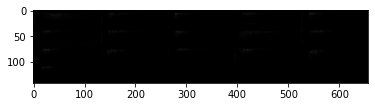

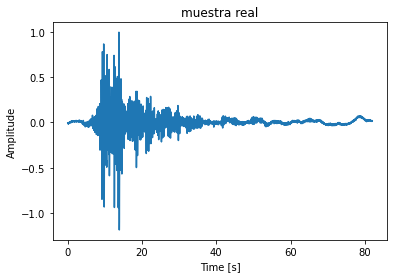

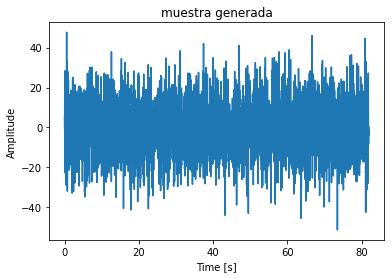

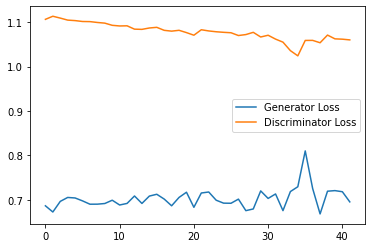

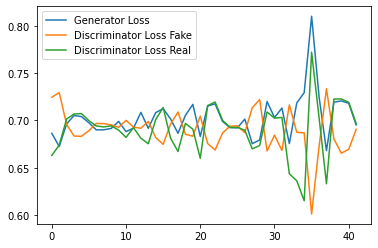

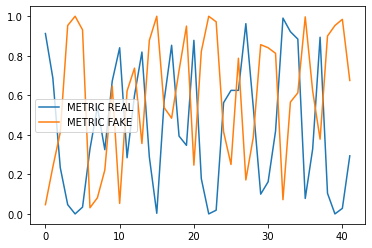

Step 900: Generator loss: 0.6789666357040405, discriminator loss: 1.0465544545650483
Espectrogramas Generados


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


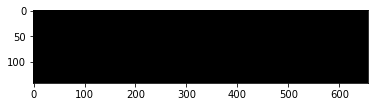

Espectrogramas Reales


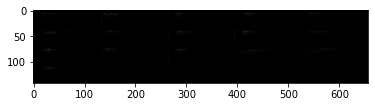

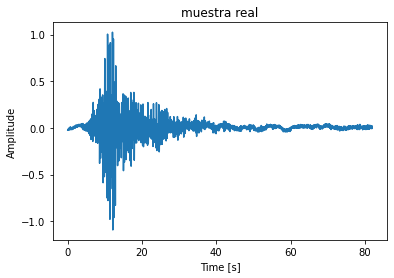

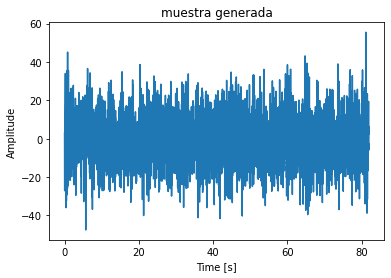

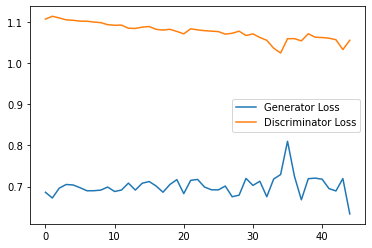

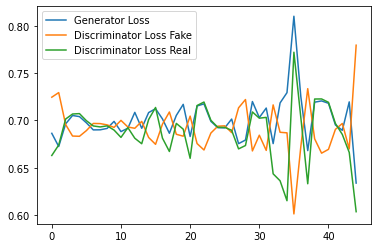

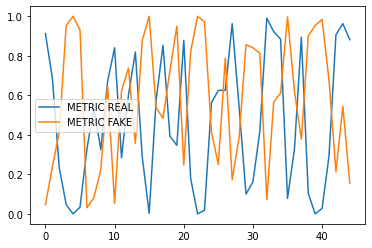

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 950: Generator loss: 0.7218763518333435, discriminator loss: 1.0573631286621095
Espectrogramas Generados


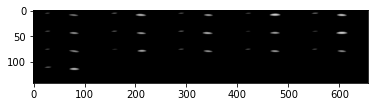

Espectrogramas Reales


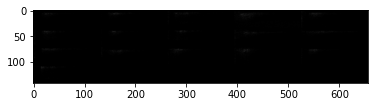

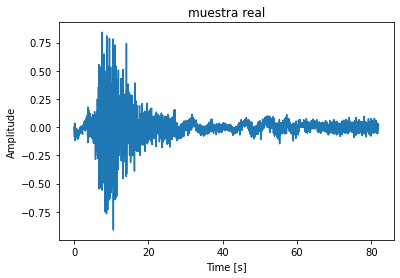

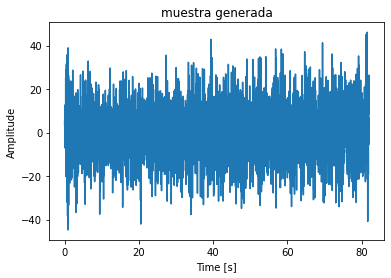

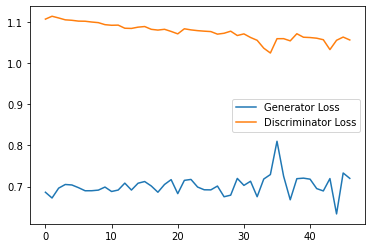

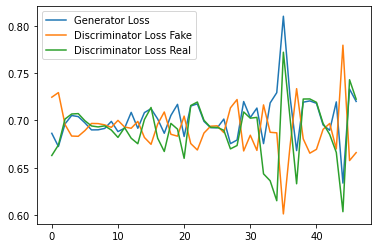

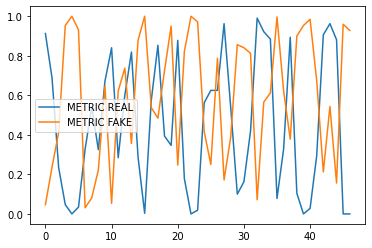

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 0.6985634326934813, discriminator loss: 1.0443353939056397
Espectrogramas Generados


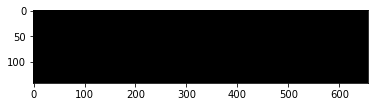

Espectrogramas Reales


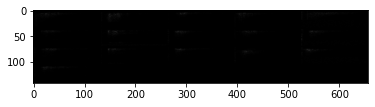

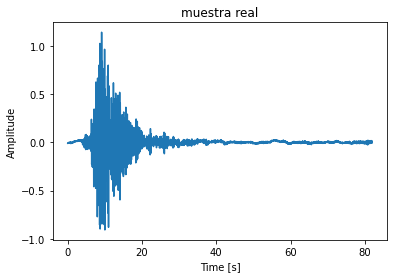

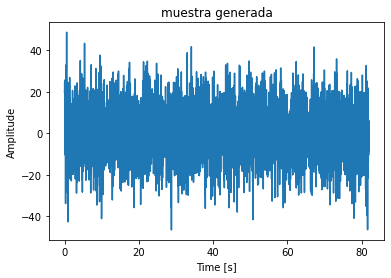

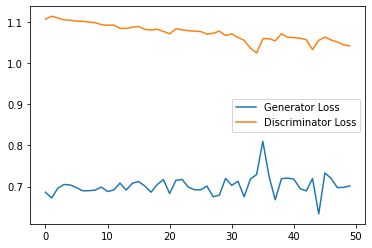

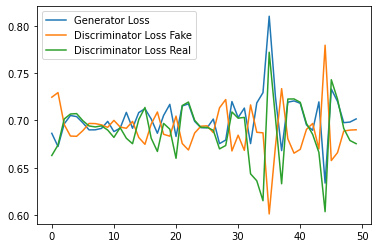

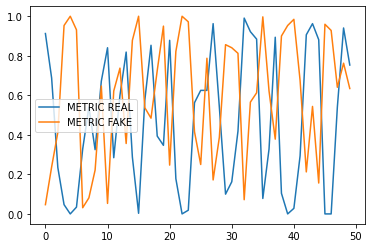

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1050: Generator loss: 0.7079976811408996, discriminator loss: 1.0459891033172608
Espectrogramas Generados


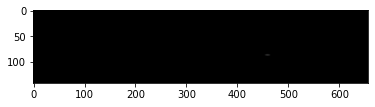

Espectrogramas Reales


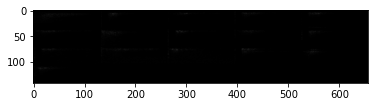

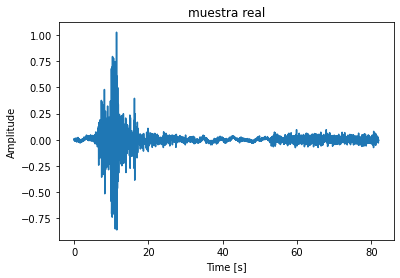

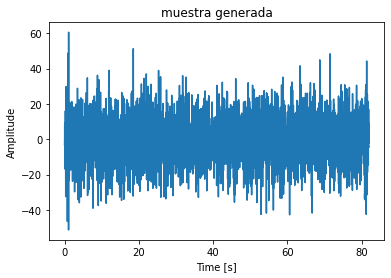

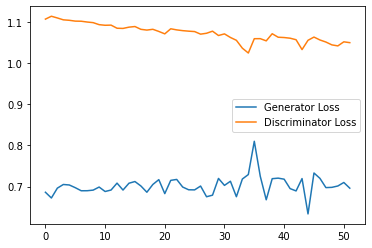

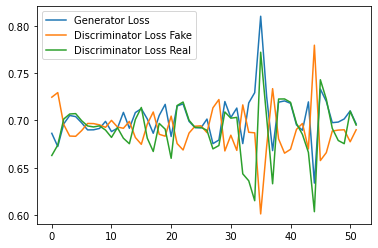

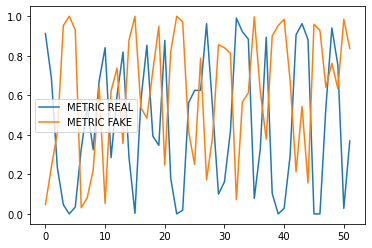

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1100: Generator loss: 0.6883242712020875, discriminator loss: 1.0432248520851135
Espectrogramas Generados


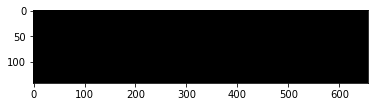

Espectrogramas Reales


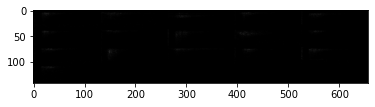

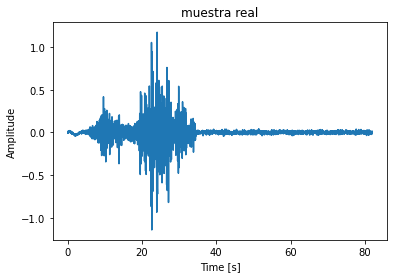

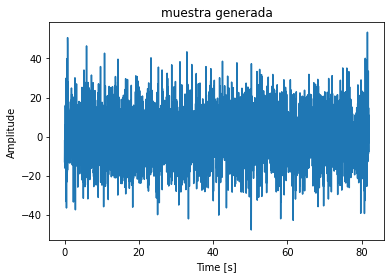

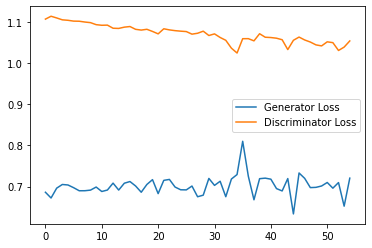

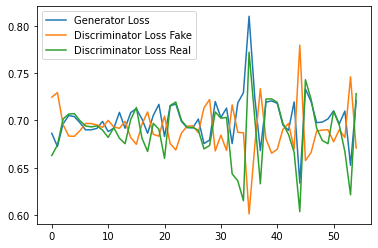

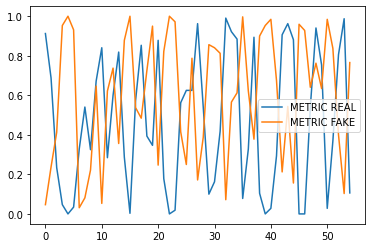

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1150: Generator loss: 0.7002128747701643, discriminator loss: 1.0389047837257386
Espectrogramas Generados


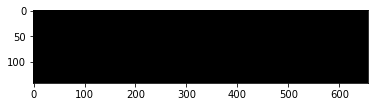

Espectrogramas Reales


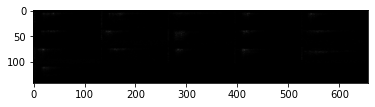

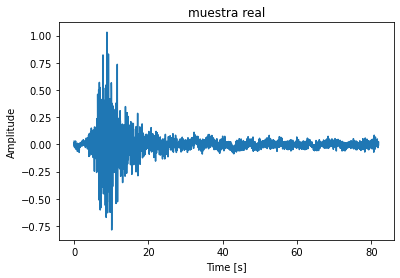

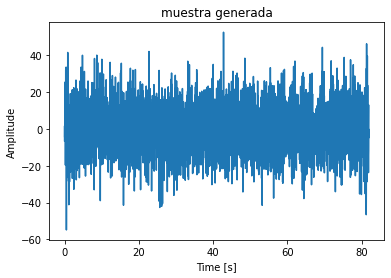

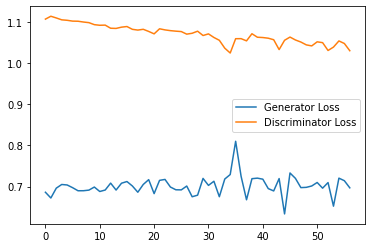

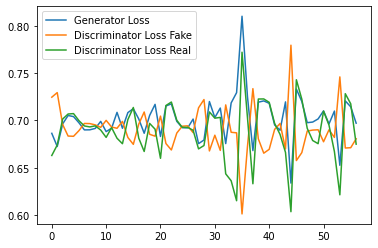

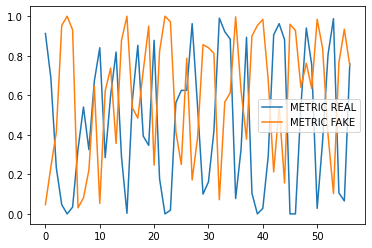

Epoch: 3


  0%|          | 0/385 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1200: Generator loss: 0.7074946553707123, discriminator loss: 1.0430848979949952
Espectrogramas Generados


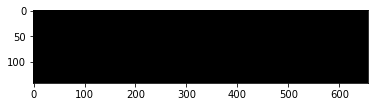

Espectrogramas Reales


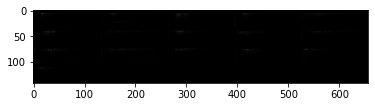

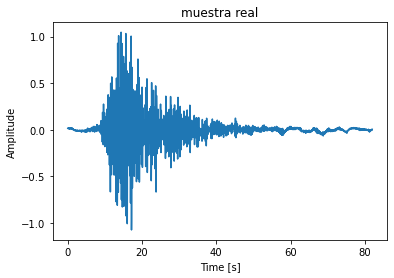

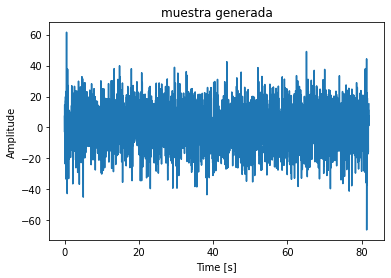

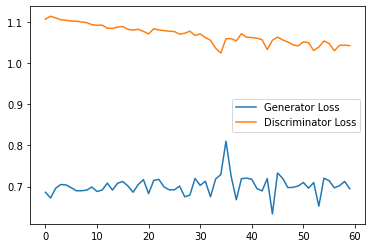

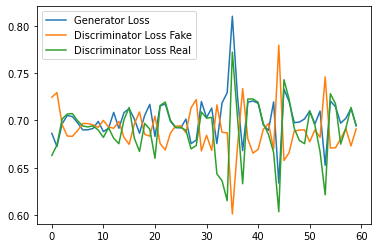

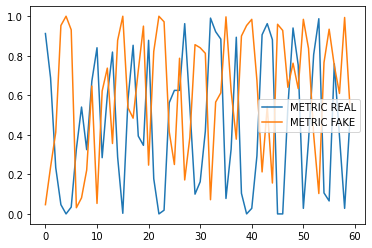

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250: Generator loss: 0.7749614415168766, discriminator loss: 0.9457099914550782
Espectrogramas Generados


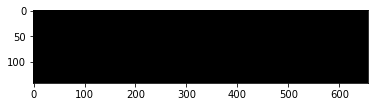

Espectrogramas Reales


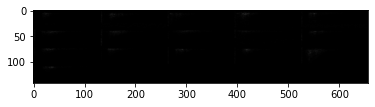

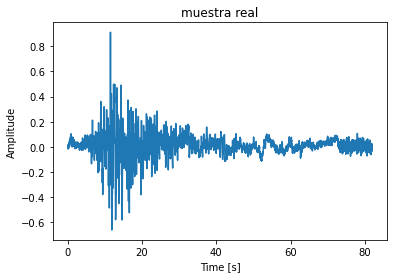

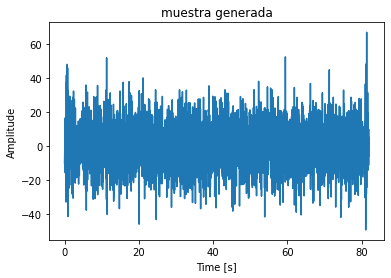

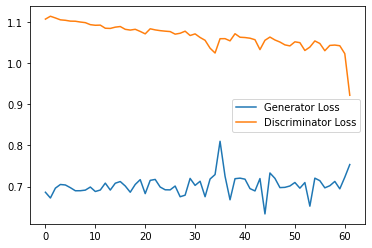

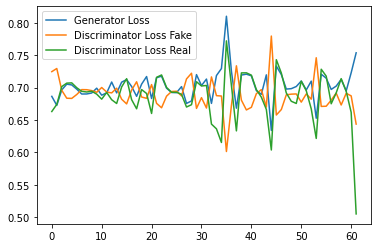

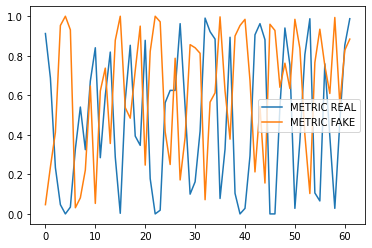

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1300: Generator loss: 0.9254802669286728, discriminator loss: 0.9934161102771759
Espectrogramas Generados


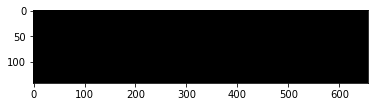

Espectrogramas Reales


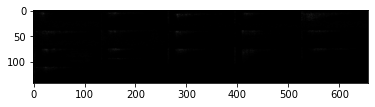

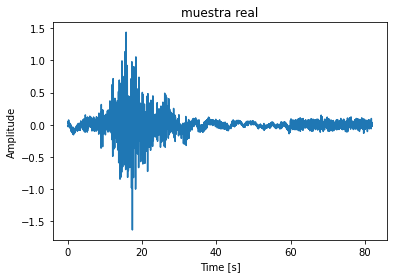

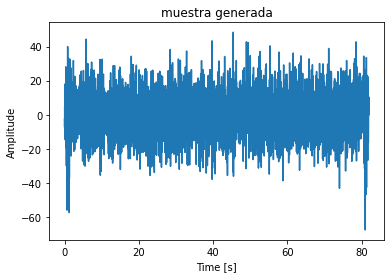

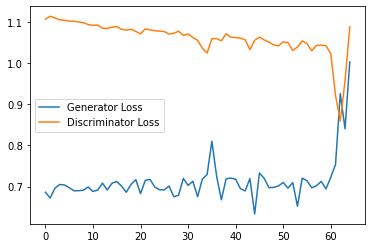

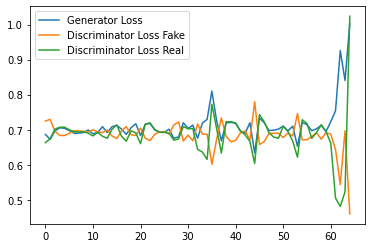

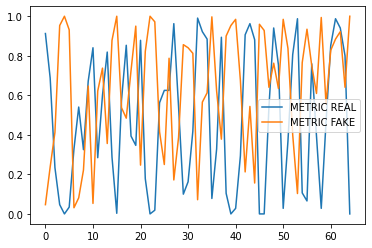

Step 1350: Generator loss: 0.7225866992473604, discriminator loss: 1.005266968011856
Espectrogramas Generados


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


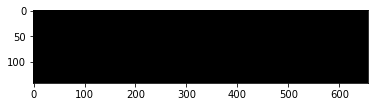

Espectrogramas Reales


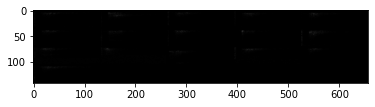

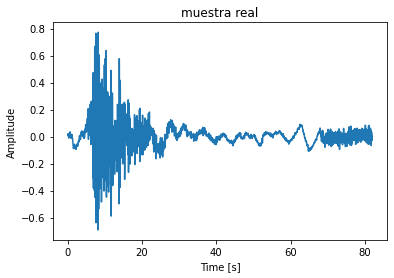

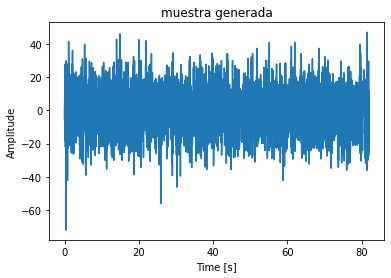

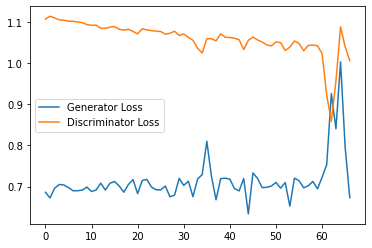

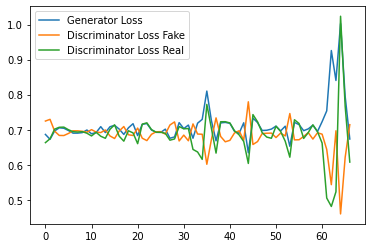

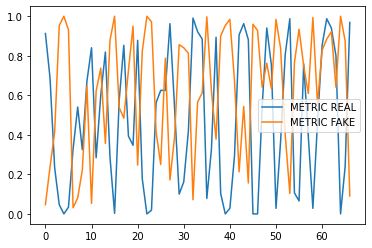

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1400: Generator loss: 0.7239575004577635, discriminator loss: 1.040065245628357
Espectrogramas Generados


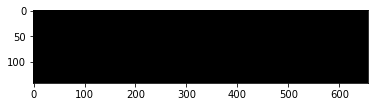

Espectrogramas Reales


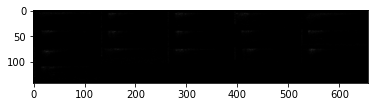

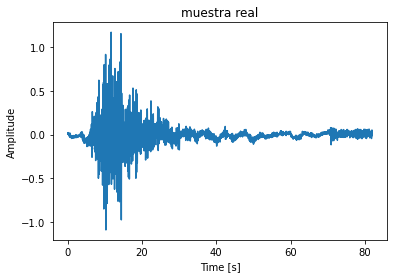

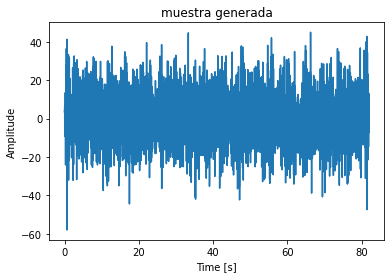

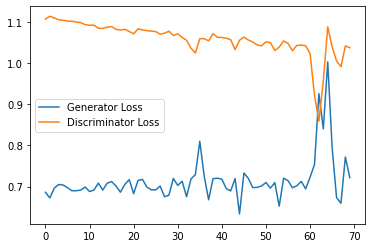

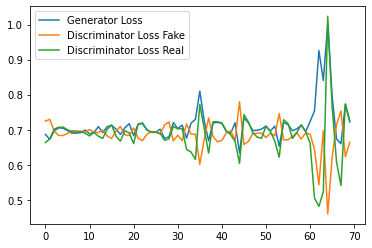

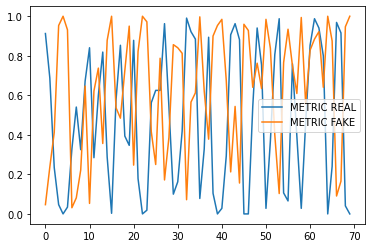

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1450: Generator loss: 0.6960449268817902, discriminator loss: 1.0335350275039672
Espectrogramas Generados


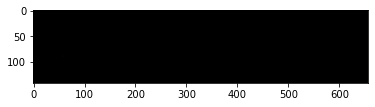

Espectrogramas Reales


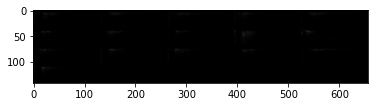

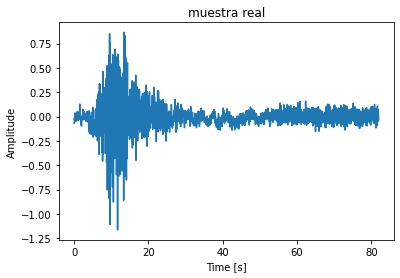

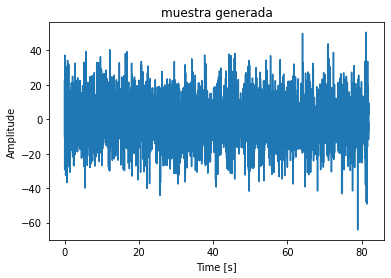

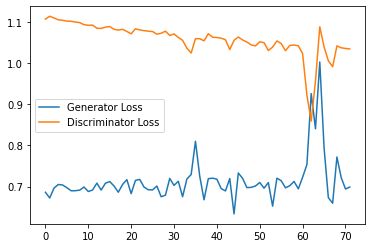

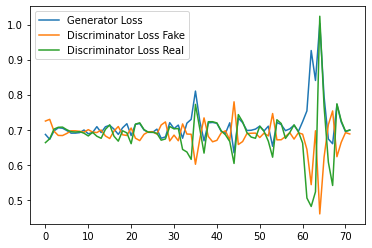

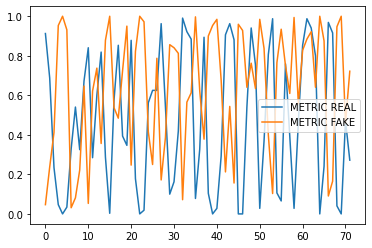

Step 1500: Generator loss: 0.6657397278547288, discriminator loss: 1.0368049716949463
Espectrogramas Generados


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


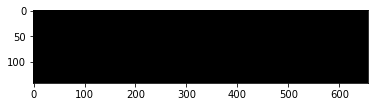

Espectrogramas Reales


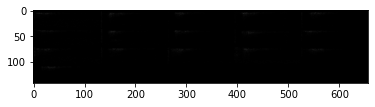

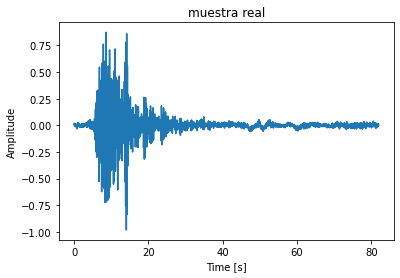

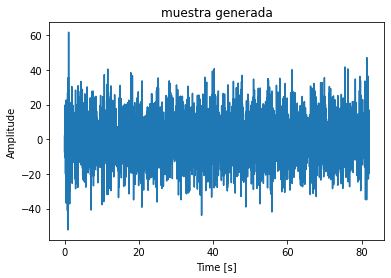

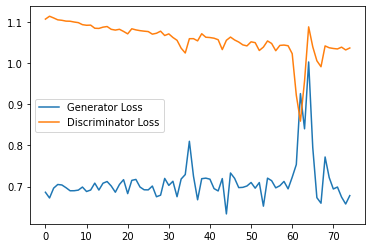

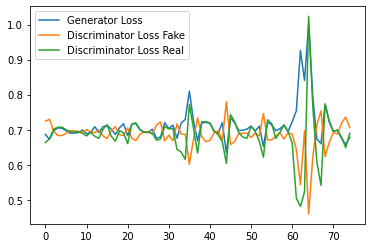

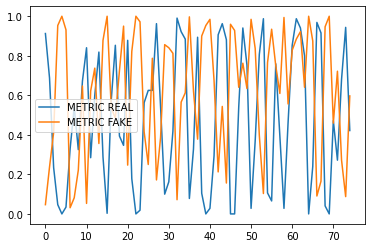

Epoch: 4


  0%|          | 0/385 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1550: Generator loss: 0.7036981976032258, discriminator loss: 1.0403105473518373
Espectrogramas Generados


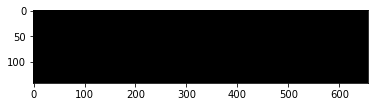

Espectrogramas Reales


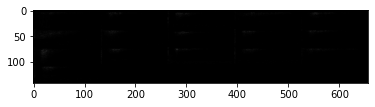

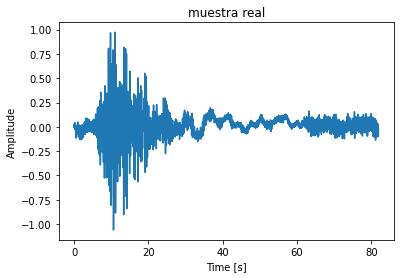

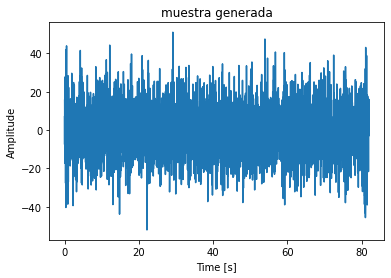

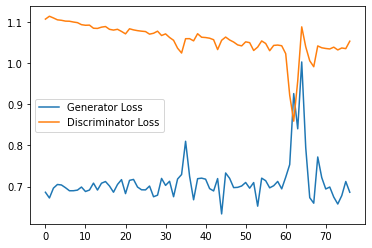

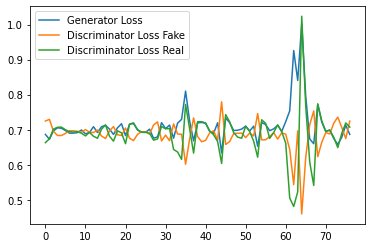

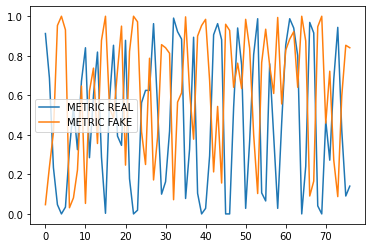

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1600: Generator loss: 0.6976900429725644, discriminator loss: 1.028614103794098
Espectrogramas Generados


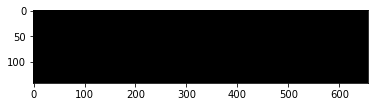

Espectrogramas Reales


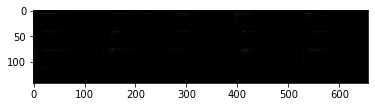

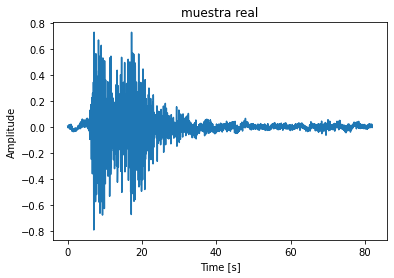

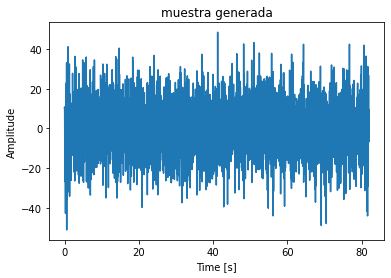

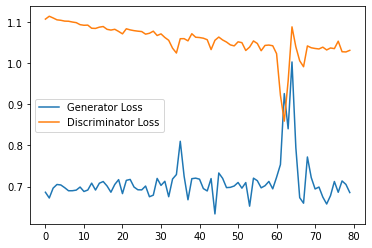

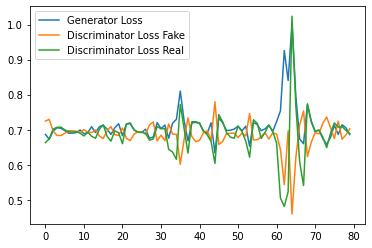

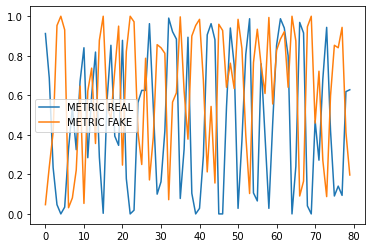

KeyboardInterrupt: 

In [30]:
cur_step = 0
generator_losses = []
discriminator_losses = []
discriminator_losses_real = []
discriminator_losses_fake = []
metric_real = []
metric_fake = [] 

for epoch in range(epoch_temp + 1, n_epochs):
    print('Epoch: ' + str(epoch))
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = auxiliares.get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = auxiliares.get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)#gen.forward(noise_and_labels) no usar

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        fake_image_and_labels = auxiliares.combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = auxiliares.combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)               
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        metric_fake += [metric(disc_fake_pred, torch.zeros_like(disc_fake_pred)).item()]
        metric_real += [metric(disc_real_pred, torch.ones_like(disc_real_pred)).item()]
        
        disc_loss = ((disc_fake_loss + disc_real_loss)/2)
        
        if regularizaM:
            l2_reg = None
            for W in disc.parameters():
                if l2_reg is None:
                    l2_reg = W.norm(2)
                else:
                    l2_reg = l2_reg + W.norm(2)
            disc_loss = disc_loss +  l2_reg * reg_lambda 
        
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses_real += [disc_real_loss.item()]
        discriminator_losses_fake+= [disc_fake_loss.item()]
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        mean_iteration_gen_loss = 0
        for _ in range(repeats_g):
            gen_opt.zero_grad()
            fake_noise_2 = auxiliares.get_noise(cur_batch_size, z_dim, device=device)       
            noise_and_labels_2 = auxiliares.combine_vectors(fake_noise_2, one_hot_labels)
            fake_2 = gen(noise_and_labels_2)   
            fake_image_and_labels = auxiliares.combine_vectors(fake_2, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            mean_iteration_gen_loss += gen_loss.item() / repeats_g    
            gen_loss.backward()
            gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [mean_iteration_gen_loss]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            print(f"Espectrogramas Generados")
            visualizacion.show_tensor_images(torch.transpose(fake, 2, 3), size=(1, 129, 33))
            print(f"Espectrogramas Reales")
            visualizacion.show_tensor_images(torch.transpose(real, 2, 3), size=(1, 129, 33))
            visualizacion.show_time_domine_images(torch.transpose(real, 2, 3), size=(1, 129, 33), std=std, mean=mean, real = True)
            visualizacion.show_time_domine_images(torch.transpose(fake, 2, 3), size=(1, 129, 33), std=std, mean=mean, real = False)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            
            plt.show()
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses_fake[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss Fake"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses_real[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss Real"
            )
            plt.legend()
            
            plt.show()
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(metric_real[:num_examples]).view(-1, step_bins).mean(1),
                label="METRIC REAL"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(metric_fake[:num_examples]).view(-1, step_bins).mean(1),
                label="METRIC FAKE"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Red Funcionando")
        cur_step += 1 
    if((guardar and epoch % save_steep == 0) or epoch == n_epochs - 1):
        Checkpoint.save_weighs(gen, disc, gen_opt, disc_opt, epoch, gen_loss, disc_loss, nombre)
        print('epoch guardada')                

In [ ]:
#gen.state_dict()

In [ ]:
from torchvision import models
from torchsummary import summary

summary(gen, (66,1,1))

summary(disc, (3,129,33))

In [ ]:
gen.eval()
disc.eval()

In [ ]:
import PrePross.grifflin as grifflin
import numpy as np

examples = 1

for i in range(examples):
    x = torch.tensor([1])
    one_hot_labels = auxiliares.get_one_hot_labels(x.to(device), n_classes)
    fake_noise = auxiliares.get_noise(1, z_dim, device=device)
    noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels)
    fake = fake.cpu().detach().numpy()
    
    #fake = real[1].cpu().detach().numpy()
    #fake = np.expand_dims(fake, axis=1)
    
    #real, label = myData.__getitem__(852)
    #fake = real.cpu().detach().numpy()
    #fake = np.expand_dims(fake, axis=1)
    
    fake = fake * std + mean
    samplerate = 50
    timee, muestra_rec=grifflin.reconstruir_señal_generador(fake, 1000, samplerate)
    muestra_rec = np.squeeze(muestra_rec)
    tamaño = len(muestra_rec) / samplerate
    time = np.linspace(0., tamaño, len(muestra_rec))
    plt.plot(time,muestra_rec)
    plt.title("Señal Recuperada")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()
    

In [ ]:
print(real)